In [13]:
# Cell 1: Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_rand_score, homogeneity_score
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import ParameterGrid
from collections import Counter

In [14]:
# Set random seed for reproducibility
np.random.seed(42)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

In [16]:
# Cell 2: Load and explore the data
df = pd.read_csv('./balanced_ecg_multiclass.csv')

df.head()


,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,Feature10,...,Feature21,Feature22,Feature23,Feature24,Feature25,Feature26,Feature27,Feature28,Feature29,target
0,-1.944044,1.891310,5.378017,-1.099764,0.319998,-0.107990,0.192998,-0.531588,-1.978358,0.505306,...,0.435838,-0.375777,-2.410484,1.307302,-0.447091,-1.205613,-0.758668,-1.115528,1.219782,8
1,0.548890,3.689146,-1.079215,-1.125497,6.892610,-0.114086,-0.129833,-4.471123,1.281707,2.509007,...,-0.515136,-1.814937,-0.659753,0.092014,1.173449,-0.887015,-0.657684,0.676340,0.379053,8
2,1.044743,2.804073,-1.779122,-0.358211,6.132624,-1.309396,-0.731316,-3.381683,-1.444734,3.028355,...,-0.928873,-1.592203,-0.389953,0.343527,0.740160,-0.244341,-1.337129,-0.168281,-0.464880,8
3,-2.848743,-2.220174,-0.498797,-0.054547,0.073406,0.927517,1.891807,-0.381548,0.017551,0.659493,...,0.662054,0.671306,-0.463003,-0.170516,0.249816,0.019505,-0.380889,-0.222127,0.364851,8
4,-0.715628,0.217362,2.032461,-0.144826,4.375660,-1.762026,1.335940,1.742721,-1.771379,0.819612,...,-0.428352,-0.511074,-0.346423,0.137622,-0.289325,-1.089344,-0.407556,-0.007071,0.117600,8


In [17]:
print("Class Ditribution:")
df['target'].value_counts()

Class Ditribution:


target
8     367
3     367
13    367
2     367
4     367
5     367
14    367
6     367
10    367
1     367
11    367
7     367
0     367
12    367
9     367
Name: count, dtype: int64

In [18]:
# Separate features and target
X = df.drop('target', axis=1)
y = df['target']

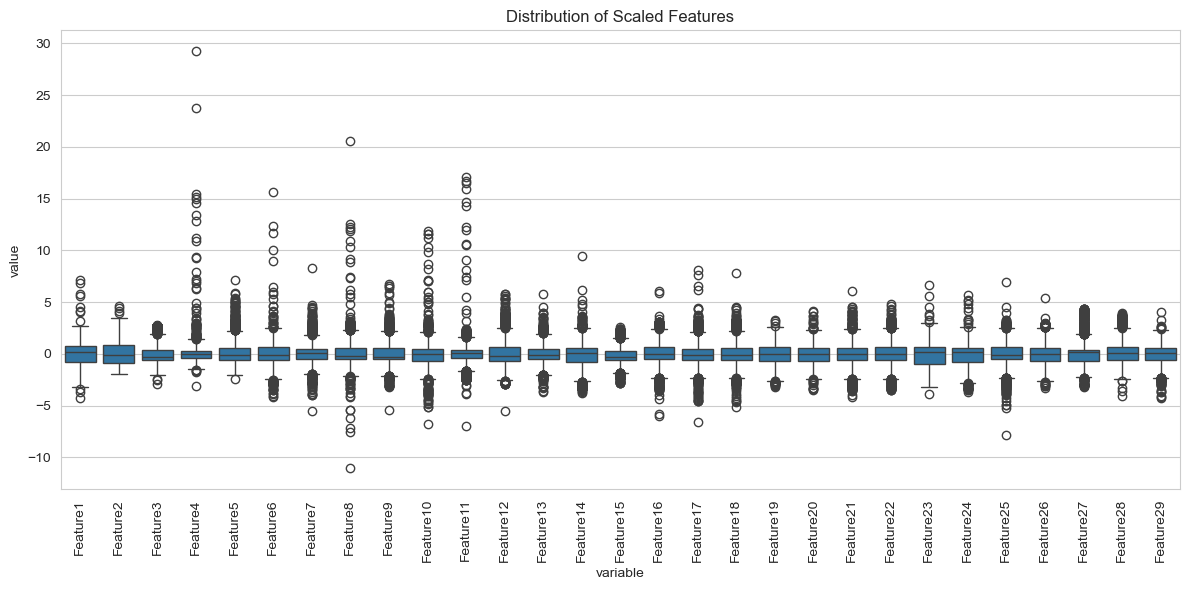

In [19]:
# ⚠️ Normalize data (DBSCAN is sensitive to scale)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Visualize feature distributions
plt.figure(figsize=(12, 6))
sns.boxplot(data=pd.DataFrame(X_scaled, columns=X.columns).melt(), x='variable', y='value')
plt.title('Distribution of Scaled Features')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

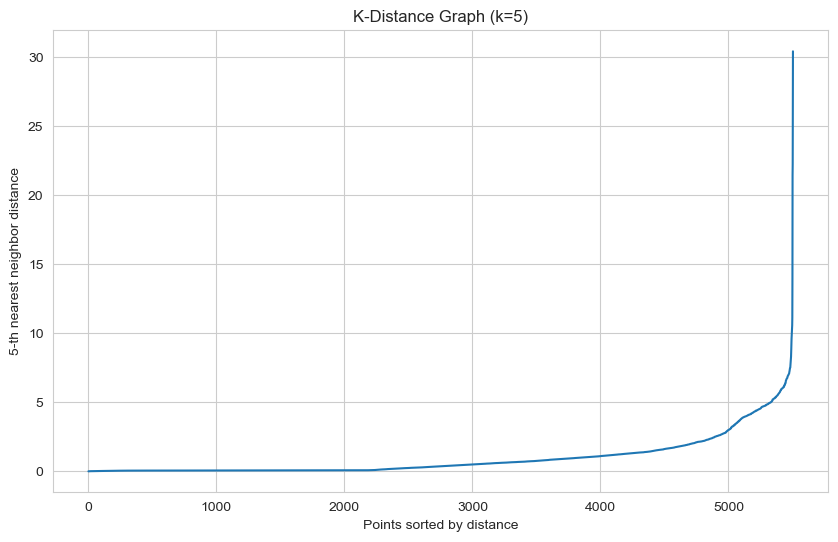

Suggested eps value from k-distance graph: 11.13


In [20]:
# Cell 4: Determine optimal eps parameter using k-distance graph
def find_optimal_eps(X, k=5):
    neigh = NearestNeighbors(n_neighbors=k)
    neigh.fit(X)
    distances, _ = neigh.kneighbors(X)
    distances = np.sort(distances[:, k-1], axis=0)
    
    plt.figure(figsize=(10, 6))
    plt.plot(distances)
    plt.title(f'K-Distance Graph (k={k})')
    plt.xlabel('Points sorted by distance')
    plt.ylabel(f'{k}-th nearest neighbor distance')
    plt.grid(True)
    plt.show()
    
    # The point of maximum curvature is often a good eps value
    return distances[np.argmax(np.gradient(np.gradient(distances)))]

optimal_eps = find_optimal_eps(X_scaled)
print(f"Suggested eps value from k-distance graph: {optimal_eps:.2f}")

Top 5 parameter combinations by ARI:
         eps  min_samples       ARI  Homogeneity  n_clusters  noise_points
42  2.166667            3  0.898140     0.972750          57           474
43  2.166667            4  0.887420     0.964112          45           520
49  2.444444            3  0.869649     0.945649          41           444
35  1.888889            3  0.869212     0.963584          79           519
50  2.444444            4  0.860449     0.939345          33           476


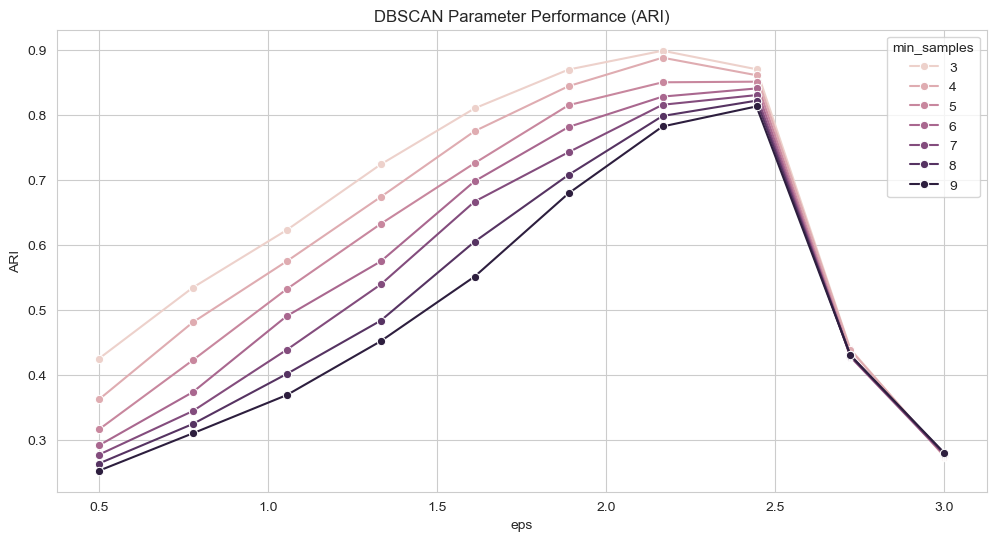

In [21]:
# Cell 5: Parameter tuning for DBSCAN
def evaluate_dbscan(X, y, eps_range, min_samples_range):
    results = []
    param_grid = {'eps': eps_range, 'min_samples': min_samples_range}
    
    for params in ParameterGrid(param_grid):
        dbscan = DBSCAN(**params)
        labels = dbscan.fit_predict(X)
        
        # Only calculate metrics if there are clusters found (excluding noise)
        if len(set(labels)) > 1:
            ari = adjusted_rand_score(y, labels)
            homogeneity = homogeneity_score(y, labels)
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            noise_points = list(labels).count(-1)
            results.append({
                'eps': params['eps'],
                'min_samples': params['min_samples'],
                'ARI': ari,
                'Homogeneity': homogeneity,
                'n_clusters': n_clusters,
                'noise_points': noise_points
            })
    
    return pd.DataFrame(results)

# Define parameter ranges
eps_range = np.linspace(0.5, 3.0, 10)
min_samples_range = range(3, 10)

# Run parameter search
results_df = evaluate_dbscan(X_scaled, y, eps_range, min_samples_range)

# Display top 5 parameter combinations by ARI
print("Top 5 parameter combinations by ARI:")
print(results_df.sort_values('ARI', ascending=False).head(5))

# Visualize parameter performance
plt.figure(figsize=(12, 6))
sns.lineplot(data=results_df, x='eps', y='ARI', hue='min_samples', marker='o')
plt.title('DBSCAN Parameter Performance (ARI)')
plt.show()

In [22]:
# Cell 6: Run DBSCAN with optimal parameters
# Using parameters from the tuning step (adjust based on your results)
optimal_params = results_df.sort_values('ARI', ascending=False).iloc[0]
dbscan = DBSCAN(eps=optimal_params['eps'], min_samples=int(optimal_params['min_samples']))
y_cluster = dbscan.fit_predict(X_scaled)

# Evaluate clustering
ari_score = adjusted_rand_score(y, y_cluster)
homogeneity = homogeneity_score(y, y_cluster)
n_clusters = len(set(y_cluster)) - (1 if -1 in y_cluster else 0)
noise_points = list(y_cluster).count(-1)

print(f"Optimal Parameters: eps={optimal_params['eps']:.2f}, min_samples={optimal_params['min_samples']}")
print(f"ARI Score: {ari_score:.4f}")
print(f"Homogeneity Score: {homogeneity:.4f}")
print(f"Number of clusters found: {n_clusters}")
print(f"Number of noise points: {noise_points} ({noise_points/len(y)*100:.2f}%)")

# Cluster distribution
cluster_counts = Counter(y_cluster)
print("\nCluster Distribution:")
for cluster, count in cluster_counts.items():
    print(f"Cluster {cluster}: {count} points")

Optimal Parameters: eps=2.17, min_samples=3.0
ARI Score: 0.8981
Homogeneity Score: 0.9728
Number of clusters found: 57
Number of noise points: 474 (8.61%)

Cluster Distribution:
Cluster -1: 474 points
Cluster 0: 28 points
Cluster 1: 224 points
Cluster 2: 4 points
Cluster 3: 5 points
Cluster 4: 9 points
Cluster 5: 10 points
Cluster 6: 5 points
Cluster 7: 15 points
Cluster 8: 5 points
Cluster 9: 5 points
Cluster 10: 3 points
Cluster 11: 4 points
Cluster 12: 5 points
Cluster 13: 3 points
Cluster 14: 4 points
Cluster 15: 3 points
Cluster 16: 3 points
Cluster 17: 367 points
Cluster 18: 323 points
Cluster 19: 41 points
Cluster 20: 367 points
Cluster 21: 367 points
Cluster 22: 8 points
Cluster 23: 14 points
Cluster 24: 8 points
Cluster 25: 41 points
Cluster 26: 10 points
Cluster 27: 5 points
Cluster 28: 7 points
Cluster 29: 78 points
Cluster 30: 15 points
Cluster 31: 25 points
Cluster 32: 90 points
Cluster 33: 5 points
Cluster 34: 4 points
Cluster 35: 3 points
Cluster 36: 3 points
Cluster 37:

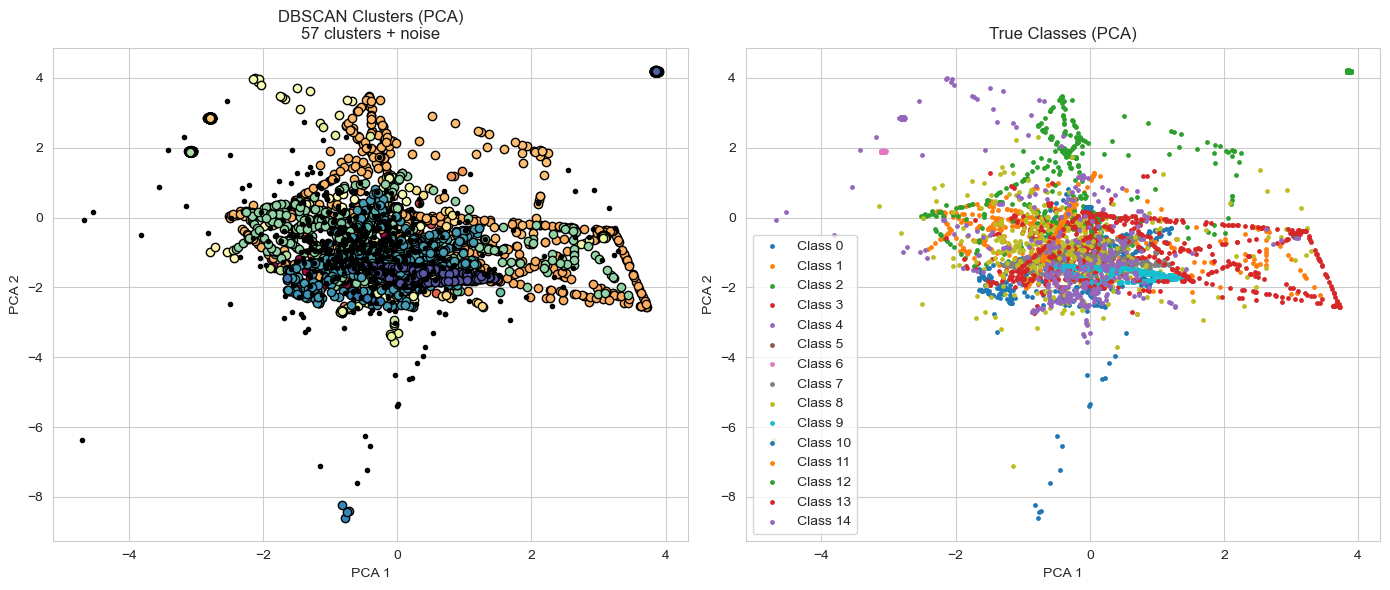

c:\Users\rajit\anaconda3\envs\ml_env\lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


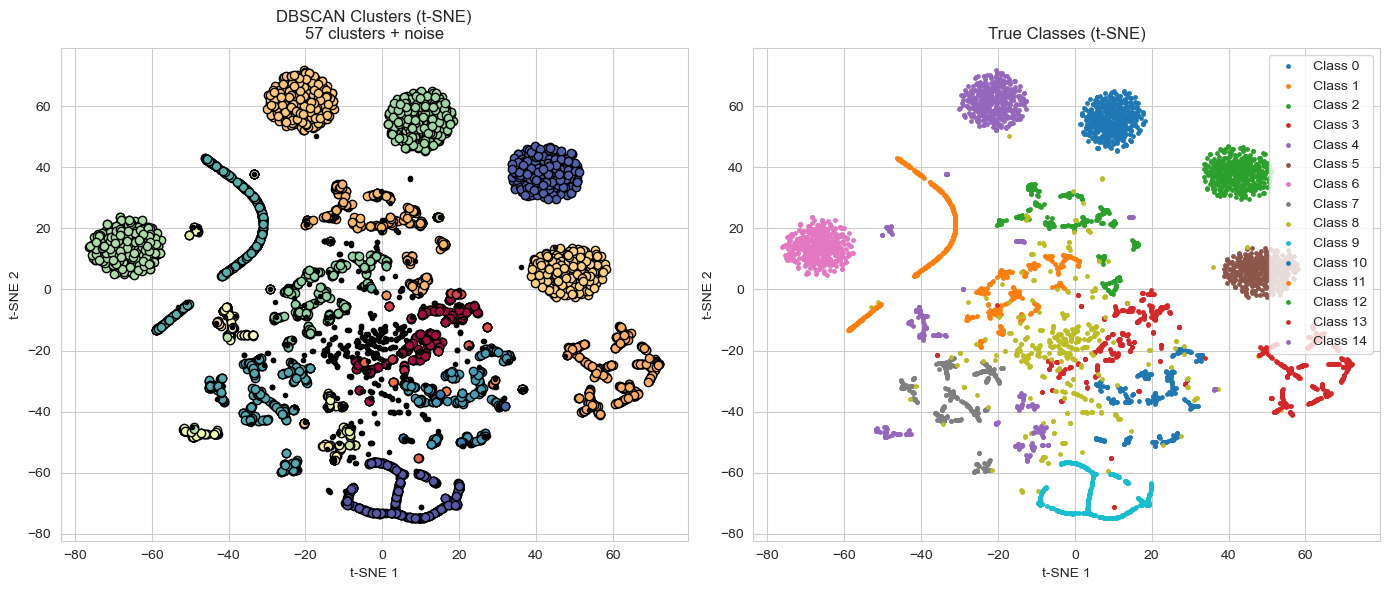

In [24]:
# Cell 7: Dimensionality reduction for visualization
def plot_clusters(X_red, y_cluster, y_true, title, method_name):
    plt.figure(figsize=(14, 6))
    
    # Plot clustering results
    plt.subplot(1, 2, 1)
    unique_labels = set(y_cluster)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    
    for k, col in zip(unique_labels, colors):
        if k == -1:
            col = [0, 0, 0, 1]  # Black for noise
        
        class_member_mask = (y_cluster == k)
        xy = X_red[class_member_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=6 if k != -1 else 3)
    
    plt.title(f'DBSCAN Clusters ({method_name})\n{len(unique_labels)-1} clusters + noise')
    plt.xlabel(f'{method_name} 1')
    plt.ylabel(f'{method_name} 2')
    
    # Plot true labels for comparison
    plt.subplot(1, 2, 2)
    for label in set(y_true):
        mask = (y_true == label)
        plt.scatter(X_red[mask, 0], X_red[mask, 1], label=f'Class {label}', s=6)
    
    plt.title(f'True Classes ({method_name})')
    plt.xlabel(f'{method_name} 1')
    plt.ylabel(f'{method_name} 2')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

# PCA visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)
plot_clusters(X_pca, y_cluster, y, 'PCA Visualization', 'PCA')

# t-SNE visualization (takes longer but often better separation)
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X_scaled)
plot_clusters(X_tsne, y_cluster, y, 't-SNE Visualization', 't-SNE')

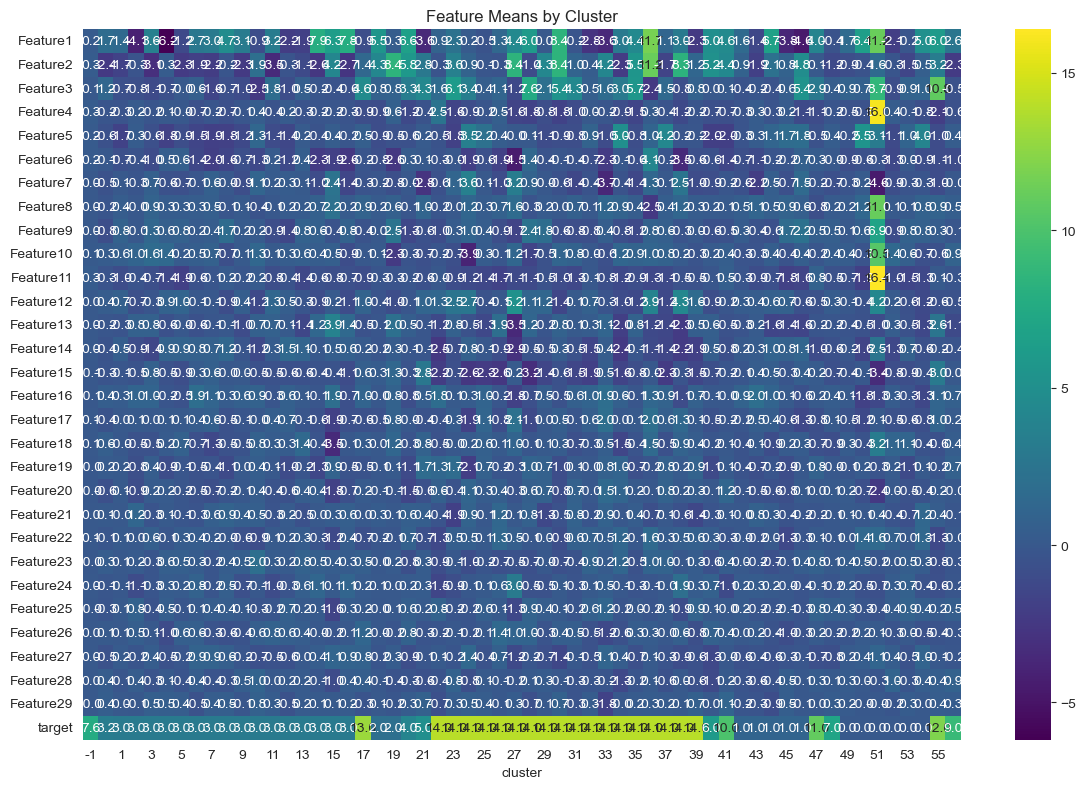

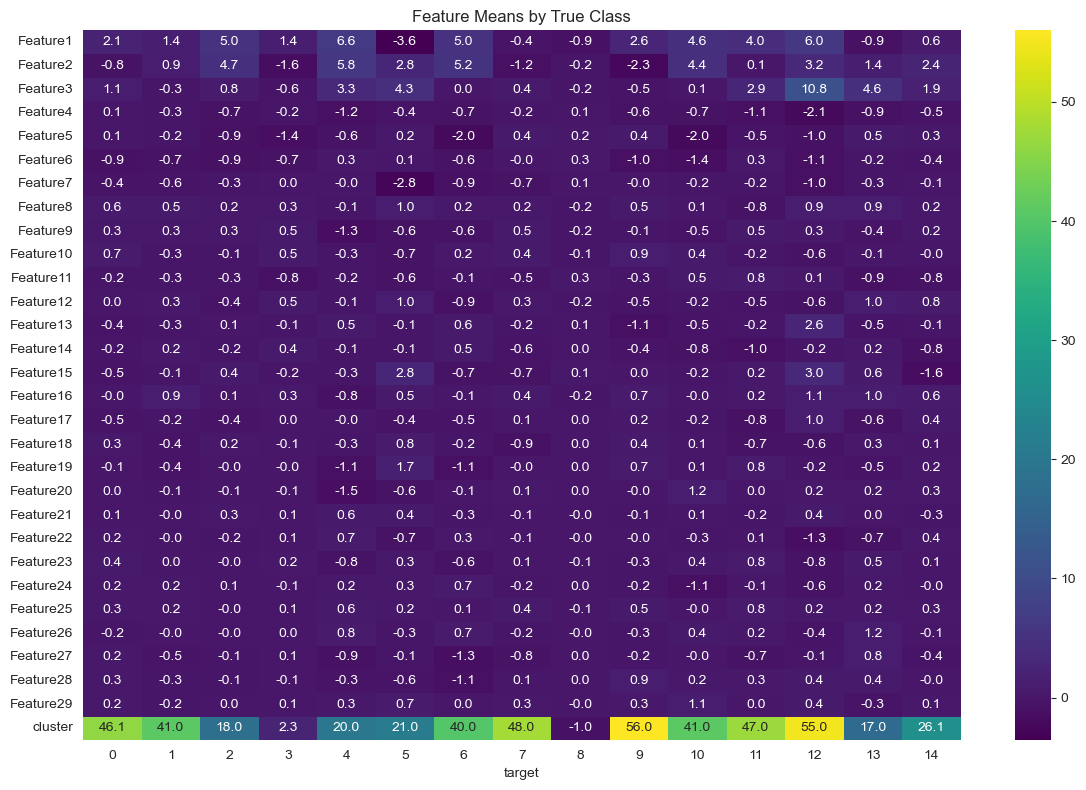

In [25]:
# Cell 8: Analyze cluster characteristics
# Add cluster labels to the original dataframe
df['cluster'] = y_cluster

# Analyze feature means by cluster
cluster_stats = df.groupby('cluster').mean()
plt.figure(figsize=(12, 8))
sns.heatmap(cluster_stats.T, cmap='viridis', annot=True, fmt='.1f')
plt.title('Feature Means by Cluster')
plt.tight_layout()
plt.show()

# Compare with true class means
class_stats = df.groupby('target').mean()
plt.figure(figsize=(12, 8))
sns.heatmap(class_stats.T, cmap='viridis', annot=True, fmt='.1f')
plt.title('Feature Means by True Class')
plt.tight_layout()
plt.show()

Cluster Purity: 0.9802


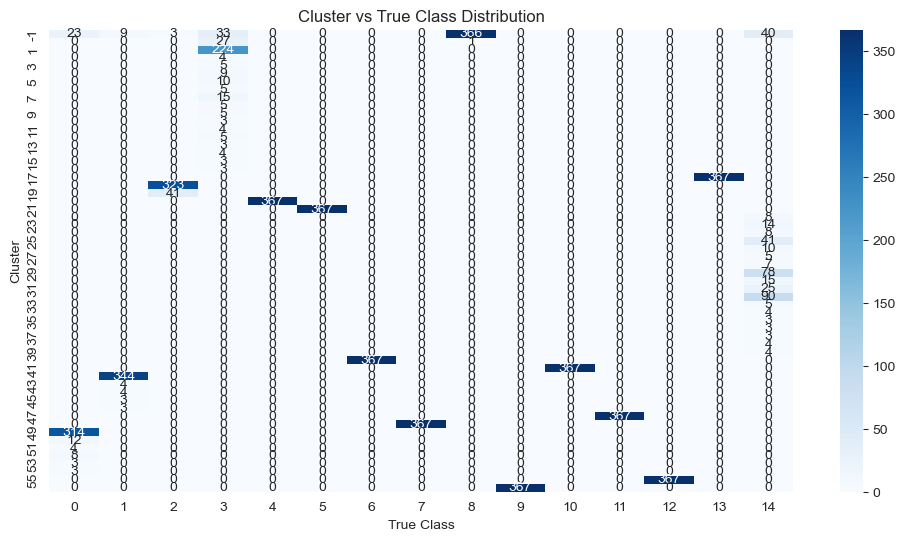

In [26]:
# Cell 9: Evaluate cluster purity
def calculate_purity(df, cluster_col, true_label_col):
    purity = 0
    for cluster in set(df[cluster_col]):
        # Get the true labels for points in this cluster
        cluster_points = df[df[cluster_col] == cluster]
        if len(cluster_points) == 0:
            continue
        
        # Find the most common true label in this cluster
        most_common = cluster_points[true_label_col].value_counts().idxmax()
        count = cluster_points[true_label_col].value_counts().max()
        
        purity += count
    
    return purity / len(df)

purity = calculate_purity(df, 'cluster', 'target')
print(f"Cluster Purity: {purity:.4f}")

# Confusion matrix between clusters and true labels
confusion_matrix = pd.crosstab(df['cluster'], df['target'])
plt.figure(figsize=(12, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Cluster vs True Class Distribution')
plt.xlabel('True Class')
plt.ylabel('Cluster')
plt.show()